# Recursive Convolutionnal Neural Network (RCNN) model

In this notebook you will find the way that we defined and trained our machine learning model.  
<span style="color:red">Cells in red should not be runned</span>

## 0. Load modules


In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating System Interaction
import os
import sys

# Machine Learning Frameworks
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

# Data Transformation and Augmentation (not all of these transformations were finally used)
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, \
    RandomVerticalFlip, ColorJitter, RandomAffine, RandomPerspective, RandomResizedCrop, \
    GaussianBlur, RandomAutocontrast
from torchvision.transforms import functional as F

# Model Building and Initialization
import torch.nn as nn
from torch.nn.init import kaiming_normal_

# Data Loading and Dataset Handling
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from PIL import Image
import json

# Cross-Validation and Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score, confusion_matrix
from scipy.special import expit as sigmoid

# Visualization and Display
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import HTML
from astropy.visualization import ImageNormalize, SqrtStretch
import seaborn as sns
import sunpy.visualization.colormaps as cm

# Miscellaneous
import random
from tqdm import tqdm

#Hand-made functions
from helper_deep_learning import *

## 1. Import the data, create the dataset, define the Dataloaders

### 1.1 Declare data path

In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    folder0_path = '... your google path to .../data0'
    folder1_path = '... your google path to .../data1'
    folder0_test_path = '... your google path to .../data0_test'
    folder1_test_path = '... your google path to .../data1_test'
    folder0_valid_path = '... your google path to .../data0_val'
    folder1_valid_path = '... your google path to .../data1_val'
    
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    #folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    #folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'
    #folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_test'
    #folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_test'
    #folder0_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'
    #folder1_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'

    #Adrien
    #folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    #folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    #folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    #folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'
    #folder0_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data0_val'
    #folder1_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data1_val'
else:
    # For local environments like VS Code
    folder0_path = '../data/data separated/data0'
    folder1_path = '../data/data separated/data1'
    folder0_test_path = '../data/data separated/data0_test'
    folder1_test_path = '../data/data separated/data1_test'
    folder0_valid_path = '../data/data separated/data0_val'
    folder1_valid_path = '../data/data separated/data1_val'

### 1.2 Declare the class and the transforms

In [3]:
class TensorTransforms:
    def __init__(self, rotate_angle=30):
        self.rotate_angle = rotate_angle

    def random_horizontal_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [2])  # Flip along width
        return x

    def random_vertical_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [1])  # Flip along height
        return x

    def random_rotation(self, x):
        # Random rotation in increments of 90 degrees for simplicity
        k = random.randint(0, 3)  # 0, 90, 180, or 270 degrees
        return torch.rot90(x, k, [1, 2])  # Rotate along height and width

    def __call__(self, x):
        x = self.random_horizontal_flip(x)
        x = self.random_vertical_flip(x)
        x = self.random_rotation(x)
        return x

class NPZDataset(Dataset):
    def __init__(self, data_dir, augment=True, mean=None, std=None):
        self.data_dir = data_dir
        self.augment = augment
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = TensorTransforms()
        self.mean = mean
        self.std = std

    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension

        data = torch.from_numpy(data).float()  # Convert to PyTorch tensor

        if self.augment: #way to improve is to add to the data
            data = self.transform(data) #there we should concatenate both data and data_transformed

        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        label = 1.0 if 'data1' in self.data_dir else 0.0

        return data, np.float32(label)

previously calculated variables :

In [4]:
mean_data = 50.564544677734375
std_data = 49.94772720336914

### 1.3 Get the data, declare the Dataloaders

In [5]:
train_data1 = NPZDataset(folder1_path, mean=mean_data, std=std_data, augment=True)
train_data0 = NPZDataset(folder0_path, mean=mean_data, std=std_data, augment=True)
train_dataset = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, mean=mean_data, std=std_data, augment=False)
test_data0 = NPZDataset(folder0_test_path, mean=mean_data, std=std_data, augment=False)
test_dataset = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, mean=mean_data, std=std_data, augment=False)
valid_data0 = NPZDataset(folder0_valid_path, mean=mean_data, std=std_data, augment=False)
validate_dataset = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

## 2. Define the CNN

In [6]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
       
        self.lstm = nn.LSTM(input_size=12800, hidden_size=256, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(32,1),
            #nn.Sigmoid()     # don't include it as it is already included in BCELogitLoss (BCELoss is less stable)
        )

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

## 3. Learning rate visualization

In [7]:
model = RCNN()
num_epochs = 100
initial_lr = 1e-4
batch_size = 2
weight_decay = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

### 3.1 Exponential decay

c:\Users\Adrien\anaconda3\envs\envADA\lib\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


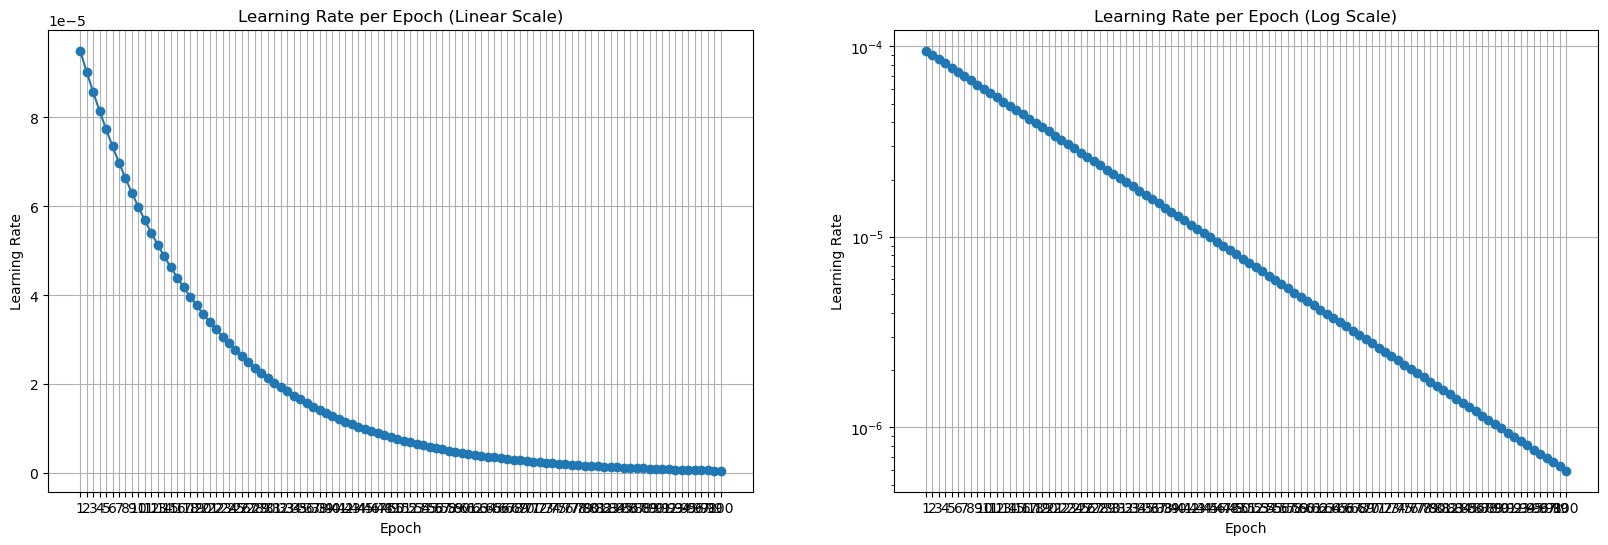

In [8]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

epochs, lrs = get_lrs(num_epochs, optimizer, scheduler)
plot_lr(epochs, lrs)

### 3.2 Cosine annealing

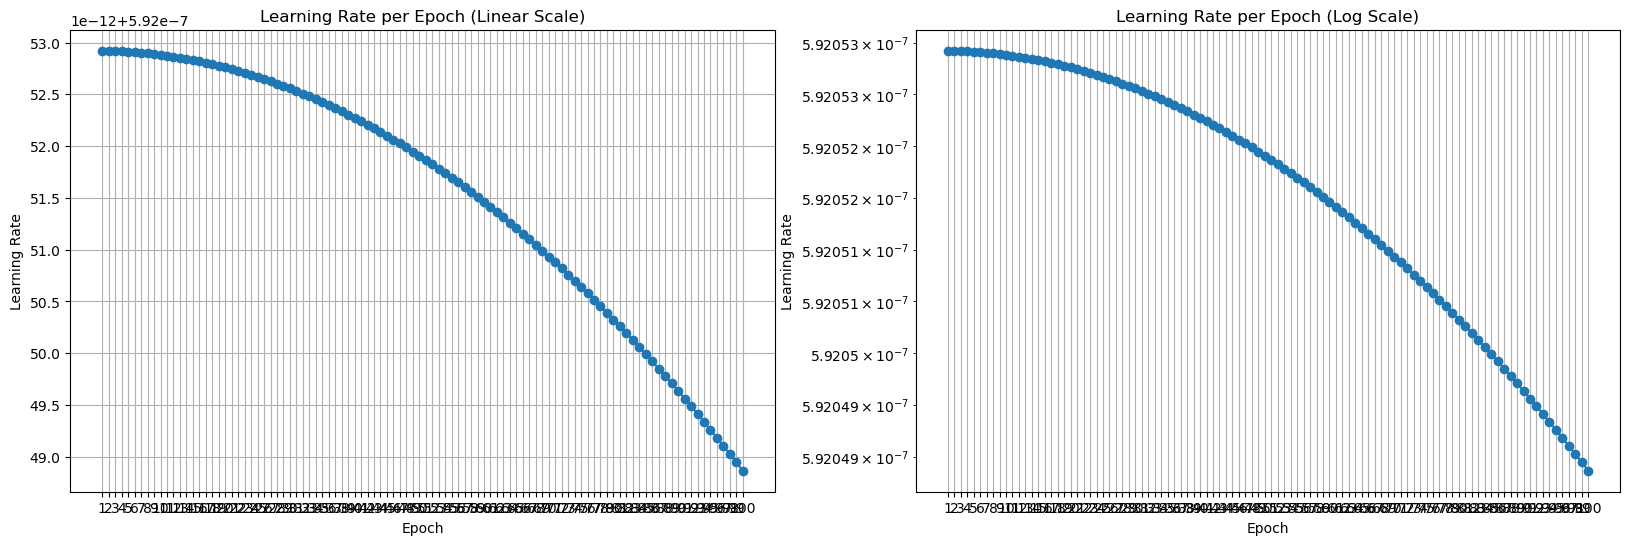

In [9]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(1200 * num_epochs) // batch_size)

epochs, lrs = get_lrs(num_epochs, optimizer, scheduler)
plot_lr(epochs, lrs)

## 4. Cross validation 

<span style="color:red">Do not run ! Computation time = 18 hours and results are already stored</span>

Results are stored in the ../model evaluation/result_cv_final.json and they will be shown and analyzed in the model evaluation section.

In [ ]:
#hyperparameters remaining constant for cross-validation, will be updated after it
num_epochs = 100
batch_size = 2
weight_decay = 5e-3
threshold = 0.5
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#Define hyperparameter crossvalidation
initial_lr = [
    1e-4,
    1e-5,
    1e-6
]

optimizers = [
    {'optimizer': torch.optim.SGD, 'weight_decay': weight_decay, 'momentum': 0.9, 'nesterov': True},
    {'optimizer': torch.optim.AdamW, 'weight_decay': weight_decay}
]

schedulers = [
    torch.optim.lr_scheduler.ExponentialLR,
    torch.optim.lr_scheduler.CosineAnnealingLR
    torch.optim.lr_scheduler.ReduceLROnPlateau
]

# Store the results of the cross_validation in a dictionnary
a=0
results_dict={}

#loop
for lr in initial_lr: 
    for optimizer_params in optimizers:
        for scheduler_type in schedulers:

            #1. initialize the model
            model = RCNN()
            model.to(device)

            #2. Define Optimizer
            optimizer_class = optimizer_params['optimizer']
            optimizer_kwargs = {key: value for key, value in optimizer_params.items() if key != 'optimizer'}

            optimizer = optimizer_class(model.parameters(), lr=lr, **optimizer_kwargs)

            #3. Define Scheduler
            if scheduler_type==torch.optim.lr_scheduler.ExponentialLR:
                scheduler_params= dict(
                    gamma=0.9
                )

            elif scheduler_type==torch.optim.lr_scheduler.CosineAnnealingLR:
                scheduler_params= dict(
                    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size
                )

            elif scheduler_type==torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler_params= dict(
                    mode='min',
                    factor=0.1,
                    patience=10,
                    threshold=1e-4,
                    threshold_mode='rel',
                    cooldown=0,
                    min_lr=0,
                    eps=1e-8,
                    verbose=False
                )
            else:
                print(f"problem with the scheduler :{scheduler_type}")
                exit()

            scheduler = scheduler_type(optimizer, **scheduler_params)

            # Logs results
            loss_history_train=[]
            lr_history_train=[]
            acc_history_train=[]

            acc_history_test=[]
            loss_history_test=[]

            f1_val_history = []

            print(f"Start of the training model {a+1} over 18")

            # Loop to update and record learning rate
            for epoch in range(1,num_epochs+1):
                # Train
                train_loss, train_acc, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, device, threshold)
                loss_history_train.append(train_loss)
                acc_history_train.append(train_acc)
                lr_history_train.append(lrs)

                # Validate
                val_loss, val_acc, val_preds, val_targets = predict(model, valid_loader, criterion, device, threshold)
                loss_history_test.append(val_loss)
                acc_history_test.append(val_acc)

                # Calculate F1 score on validation
                f1 = f1_score(val_targets, val_preds, average='binary')  # adjust the average parameter as needed
                f1_val_history.append(f1)

                if epoch == 50:
                    print(f"epoch 50: valid acc ={acc_history_test[-1]}, f1 val = {f1_val_history[-1]}")
                
                if epoch == 100:
                    print(f"epoch 100: valid acc ={acc_history_test[-1]}, f1 val = {f1_val_history[-1]}")

            #Calculate results on test set
            test_loss, test_accuracy, test_predictions, test_targets, test_out = test(model, test_loader, criterion, device, threshold)
            test_f1_score = f1_score(test_targets, test_predictions, average='binary')
            print(f"test acc ={test_accuracy}, f1 test = {test_f1_score}")

            #store results in a dictionnary

            # Hyperparameters on iteration a
            param_name = f"hyperparams_{a}"
            results_dict[param_name] = [str(lr), str(scheduler_type), str(optimizer_params['optimizer'])]

            #Accuracy on train set (100 values per model)
            acc_train_name = f"acc_train_{a}"
            results_dict[acc_train_name] = acc_history_train

            #F1 score on validation set (100 values)
            f1_valid_name = f"f1_valid_{a}"
            results_dict[f1_valid_name] = f1_val_history

            #F1 score on test set (1 value)
            f1_test_name = f"f1_test_{a}"
            results_dict[f1_test_name] = test_f1_score

            #update variable
            a+=1

with open('../model evaluation/result_cv_final.json', 'w') as file:
    json.dump(results_dict, file)

## 5. Training the final model 

In [10]:
num_epochs = 100
batch_size = 2
weight_decay = 5e-3
threshold = 0.5
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


#1. initialize the model
model = RCNN()
model.to(device)

#2. Define hyperparameter from crossvalidation

initial_lr = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size)

# Logs results
loss_history_train=[]
lr_history_train=[]
acc_history_train=[]

acc_history_val=[]
loss_history_val=[]

f1_val_history = []

# Loop to update and record learning rate
for epoch in range(1,num_epochs+1):
    # Train
    train_loss, train_acc, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, device, threshold)
    loss_history_train.append(train_loss)
    acc_history_train.append(train_acc)
    lr_history_train.append(lrs)

    # Validate
    val_loss, val_acc, val_preds, val_targets = predict(model, valid_loader, criterion, device, threshold)
    loss_history_val.append(val_loss)
    acc_history_val.append(val_acc)

    # Calculate F1 score on validation
    f1 = f1_score(val_targets, val_preds, average='binary')  # adjust the average parameter as needed
    f1_val_history.append(f1)

    if epoch == 50:
        print(f"epoch 50: valid acc ={acc_history_val[-1]}, f1 val = {f1_val_history[-1]}")
                
    if epoch == 100:
        print(f"epoch 100: valid acc ={acc_history_val[-1]}, f1 val = {f1_val_history[-1]}")

#Calculate results on test set
test_loss, test_accuracy, test_predictions, test_targets, test_out = test(model, test_loader, criterion, device, threshold)
test_f1_score = f1_score(test_targets, test_predictions, average='binary')
print(f"test acc ={test_accuracy}, f1 test = {test_f1_score}")


cuda
epoch 50: valid acc =0.8492063492063492, f1 val = 0.8442622950819672
epoch 100: valid acc =0.876984126984127, f1 val = 0.873469387755102
test acc =0.9115384615384615, f1 test = 0.9125475285171103


## 6. Save the model


In [ ]:
#torch.save(model, 'Trained_RCNN.pth')